# Trial phase characterization

In [7]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase, broader_label
from one_functions_generic import prepro, get_trials, performance_metrics, training_time, quartile

one = ONE(base_url='https://alyx.internationalbrainlab.org')

## Parameters

In [3]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Load data

In [4]:
need_to_compute = False

In [9]:
if need_to_compute:
    # Save data of all sessions for latter
    idxs = []
    mouse_names = []
    for m, mat in enumerate(design_matrices):
        
        mouse_name = design_matrices[m][51:-4]
        eid = design_matrices[m][14:50]
        idx = str(eid + '_' + mouse_name)
        if m == 0:
            idxs = idx
            mouse_names = mouse_name
        else:
            idxs = np.hstack((idxs, idx))
            mouse_names = np.hstack((mouse_names, mouse_name))
            
    # Save data of all sessions for latter
    matrix_all = defaultdict(list)
    matrix_all_unnorm = defaultdict(list)
    session_all = defaultdict(list)
    epoch_df = defaultdict(list)

    for m, mouse_name in enumerate(mouse_names):
        # Save results per mouse
        matrix_all[mouse_name] = {}
        session_all[mouse_name] = {}
        matrix_all_unnorm[mouse_name] = {}
        epoch_df[mouse_name] = {}
        
    for m, mat in enumerate(idxs):
        if len(mat) > 35: 
                
            # Trials data
            session = mat[0:36]
            mouse_name = mat[37:]

            session_trials = one.load_object(session, obj='trials', namespace='ibl')
            session_trials = session_trials.to_df()
            session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
            session_start = list(session_trials['stimOn_times'])[0]

            # Get time of last unbiased trial
            unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
            time_trial_90 = list(unbiased['stimOff_times'])[-1]
            
            filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
                    
            big_design_matrix = pickle.load(open(filename, "rb"))
            design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
            design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
            design_matrix = design_matrix.dropna()
        
            # # Keep only first 90 trials
            # design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
            # unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
            # training_set = np.array(design_matrix[var_names]).copy() 

            # Keep all session
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
            use_trials = session_trials.loc[session_trials['stimOff_times'] < session_end]
            training_set = np.array(design_matrix[var_names]).copy() 
            
            # Get trial epoch
            bins_df = bins_per_trial_phase(design_matrix, session_trials)
            bins_df = bins_df.rename(columns={0: 'Bin'})
            new_df = design_matrix.merge(bins_df, on='Bin')
            new_df = broader_label(new_df)
            
            if len(training_set) > 0:
                # Standardization using StandardScaler
                scaler = StandardScaler()
                standardized = scaler.fit_transform(training_set)
                # Normalize between 0 and 1
                normalizer = Normalizer().fit(standardized)
                normalized = normalizer.transform(standardized)
                
                matrix_all[mouse_name][session] = normalized
                session_all[mouse_name][session] = use_trials    
                matrix_all_unnorm[mouse_name][session] = design_matrix
                epoch_df[mouse_name][session] = new_df
                
            else:
                print(session)
        else:
            print(mat)


    # Get current date
    current_date = datetime.now()
    # Convert current date to string format
    date_string = current_date.strftime('%Y-%m-%d')  # Format: YYYY-MM-DD

    # Save data
    pickle.dump(matrix_all, open(str('matrix_all_'+ date_string), 'wb'))
    pickle.dump(session_all, open(str('session_all_'+date_string), 'wb'))
    pickle.dump(matrix_all_unnorm, open(str('matrix_all_unnorm_'+date_string), 'wb'))
    pickle.dump(epoch_df, open(str('epoch_df_'+date_string), 'wb'))

else:
    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
    # data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
    os.chdir(data_path)
    matrix_all = pickle.load(open('matrix_all_2024-04-04', 'rb'))
    session_all = pickle.load(open('session_all_2024-04-04', 'rb'))
    matrix_all_unnorm = pickle.load(open('matrix_all_unnorm_2024-04-04', 'rb'))
    epoch_df = pickle.load(open('epoch_df_2024-04-04', 'rb'))

## Concatenate sessions of the same animal

In [ ]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

NameError: name 'mouse_names' is not defined

## Custom functions

In [5]:
def stats_features_per_epoch(use_data, hue, label):
    
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = use_data.merge(bins_df, on='Bin')
    new_df['side'] = np.sign(new_df['signed_contrast'])
    new_df.loc[new_df['side']==0] = np.nan

    new_df['broader_label'] = new_df['label']
    new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
    new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    new_df = new_df.dropna()
    
    trial_epochs = new_df[label].unique()
    hues = new_df[hue].unique()
    vars = new_df.keys()[0:11]

    p_values = pd.DataFrame(columns=['var', 'epoch', 'significance'])
    for v, var in enumerate(vars):
        var_data = new_df[['Bin', label, var, hue]]
        
        for e, epoch in enumerate(trial_epochs):
            epoch_data = var_data.loc[var_data[label]==epoch]
            
            group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
            group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
            
            _, p_v = stats.ttest_ind(group_1, group_2)

            # Save results
            p_value = pd.DataFrame(columns=['var', 'epoch', 'significance'], index=range(1))
            p_value['var'] = var
            p_value['epoch'] = epoch
            if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly higher'
            elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly smaller'
            elif p_v >= 0.05:
                p_value['significance'] = 'Non significant'
                
            # Append
            p_values = pd.concat([p_values, p_value], ignore_index=True)
    
    # Plot 
    if hue in ['choice', 'side']:
        hue_names = np.array(['left', 'right'])
        hue_numbers = np.array([-1.0, 1.0])
    elif hue == 'correct':
        hue_names = np.array(['correct', 'incorrect'])
        hue_numbers = np.array([1., 0.])
    sns.catplot(y='var', x='significance', hue='epoch', data=p_values, 
    order=['Non significant', 'Significantly higher', 'Significantly smaller'],
    height=5, aspect=2)

    plt.title(str('Modulation by ' + hue + ' ' + str(hue_names[np.where(hue_numbers==hues[1])]) + 
                ' - ' + str(hue_names[np.where(hue_numbers==hues[0])])))
    plt.show()
            
    return p_values   

    
def stats_features_per_epoch_sess(idxs, session_all, matrix_all, matrix_all_unnorm, hue, label):
    
    p_values = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'])
    
    for m, mat in enumerate(idxs):
        if len(mat) > 35: 
                
            # Trials data
            session = mat[0:36]
            # Mouse name
            mouse_name = mat[37:]
            
            print('Testing mouse ' + mouse_name)

            # Get mouse data
            session_trials = session_all[mouse_name][session]
            design_matrix = matrix_all[mouse_name][session]
            unnorm_mat = matrix_all_unnorm[mouse_name][session]
            
            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
            " Prepare design matrix "
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix
            bins = unnorm_mat['Bin']
            design_matrix_heading['Bin'] = bins
            
            design_matrix_heading['Lick count'] = gaussian_filter1d(design_matrix_heading['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
            #plt.hist(use_data['Lick count'])
            design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])

            " Prepare data for plotting "
            bins_df = bins_per_trial_phase(design_matrix_heading, session_trials)
            bins_df = bins_df.rename(columns={0: 'Bin'})
            new_df = design_matrix_heading.merge(bins_df, on='Bin')
            new_df['side'] = np.sign(new_df['signed_contrast'])
            new_df.loc[new_df['side']==0] = np.nan

            new_df = broader_label(new_df)
            new_df = new_df.dropna()
            
            trial_epochs = new_df[label].unique()
            hues = new_df[hue].unique()
            vars = new_df.keys()[0:11]

            for v, var in enumerate(vars):
                var_data = new_df[['Bin', label, var, hue]]
                
                for e, epoch in enumerate(trial_epochs):
                    epoch_data = var_data.loc[var_data[label]==epoch]
                    
                    group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
                    group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
                    
                    _, p_v = stats.ttest_ind(group_1, group_2)

                    # Save results
                    p_value = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'], index=range(1))
                    p_value['mouse'] = mouse_name
                    p_value['var'] = var
                    p_value['epoch'] = epoch
                    if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly higher'
                    elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly smaller'
                    elif p_v >= 0.05:
                        p_value['significance'] = 'Non significant'
                        
                    # Append
                    p_values = pd.concat([p_values, p_value], ignore_index=True)
            
    return p_values 


def shuffle_control(trials_df, choice_model):
    
    shuffled_df = pd.DataFrame(columns=['Trial', 'side', 'choice', 'feedback'])

    shuffled_df['Trial'] = trials_df['Trial']
    shuffled_df['side'] = trials_df['side'].sample(frac=1).reset_index(drop=True)
    shuffled_df = shuffled_df.reset_index()

    # Compute choices from choice model
    stim_l_choice = np.where(shuffled_df['side'] == -1.)
    stim_r_choice = np.where(shuffled_df['side'] == 1.)
    
    # Choice probability
    fraction_stim_l = list(choice_model.loc[choice_model['side']==-1, 'choice'])[0]
    fraction_stim_r = list(choice_model.loc[choice_model['side']==1, 'choice'])[0]

    # Calculate the number of indexes to select
    num_indexes_stim_l = int(len(stim_l_choice[0]) * fraction_stim_l)
    num_indexes_stim_r = int(len(stim_r_choice[0]) * fraction_stim_r)

    # Generate random indices
    random_choice_r_stim_l = np.random.choice(len(stim_l_choice[0]), size=num_indexes_stim_l, replace=False)
    random_choice_r_stim_r = np.random.choice(len(stim_r_choice[0]), size=num_indexes_stim_r, replace=False)

    # Select values from the array using the random indices
    selected_values_stim_l = stim_l_choice[0][random_choice_r_stim_l]
    selected_values_stim_r = stim_r_choice[0][random_choice_r_stim_r]

    shuffled_df.loc[shuffled_df['index'].isin(selected_values_stim_l), 'choice'] = 1.
    shuffled_df.loc[shuffled_df['index'].isin(selected_values_stim_r), 'choice'] = 1.
    shuffled_df.loc[shuffled_df['choice']!=1., 'choice'] = -1.
    
    shuffled_df.loc[shuffled_df['side']==shuffled_df['choice'], 'feedback'] = 0
    shuffled_df.loc[shuffled_df['side']!=shuffled_df['choice'], 'feedback'] = 1
    
    return shuffled_df


def compute_p_value(epoch_matrix, var_names, iters, label):
    
    epoch_matrix['side'] = np.sign(epoch_matrix['signed_contrast'])
    epoch_matrix.loc[epoch_matrix['side']==0] = np.nan

    trial_epochs = epoch_matrix.dropna()[label].unique()
    hue_vals = ['side', 'choice', 'feedback']
    hues = [-1., 1.]

    trials_df = epoch_matrix[['Trial', 'feedback', 'side', 'choice']].dropna().groupby('Trial').mean().reset_index()
    trials_df.loc[trials_df['choice']==-1., 'choice'] = 0.
    choice_model = trials_df[['Trial', 'side', 'choice']].groupby('side').mean(['choice']).reset_index()

    # Loop through variables
    summary_stats = pd.DataFrame(columns=['var', 'epoch', 'hue', 'difference', 'dom', 'p_value'])
    for v, var in enumerate(var_names):
        
        # Loop through hues
        hue_stats = pd.DataFrame(columns=['var', 'epoch', 'hue', 'difference', 'dom', 'p_value'])
        for h, hue in enumerate(hue_vals):
        
            # Loop through trial epochs
            epoch_stats = pd.DataFrame(columns=['var', 'epoch', 'hue', 'difference', 'dom', 'p_value'], index=range(len(trial_epochs)))
            for e, epoch in enumerate(trial_epochs):

                var_data = epoch_matrix[['Bin', 'Trial', label, var]]
                epoch_data = var_data.loc[var_data[label]==epoch]
                
                null_d = np.ones(iters) * np.nan
                for i in range(iters):
                    
                    shuffled_df = shuffle_control(trials_df, choice_model)
                    test_data = epoch_data.merge(shuffled_df, on='Trial')
                    test_data.loc[test_data[hue]==0., hue] = -1.0

                    # Keep trial resolution here
                    group_1 = test_data.loc[test_data[hue]==hues[0]].groupby('Trial').mean([var]).reset_index()
                    group_2 = test_data.loc[test_data[hue]==hues[1]].groupby('Trial').mean([var]).reset_index()
                    
                    # Compute null distribution
                    null_d[i] = np.abs(np.nanmean(group_1[var]) - np.nanmean(group_2[var]))  # left choice minus right choice
                
                # Compute non-shuffled 
                original_data = epoch_data.merge(trials_df, on='Trial')    
                original_data.loc[original_data[hue]==0., hue] = -1.0
                
                group_1_or = original_data.loc[original_data[hue]==hues[0]].groupby('Trial').mean([var]).reset_index()
                group_2_or = original_data.loc[original_data[hue]==hues[1]].groupby('Trial').mean([var]).reset_index()
                # Average distance across observations
                original_difference = np.abs(np.nanmean(group_1_or[var]) - np.nanmean(group_2_or[var]))
                
                # save on which block is more whisking
                if (np.nanmean(group_1_or[var]) - np.nanmean(group_2_or[var])) < 0:
                    dom = '1'
                else:
                    dom = '-1'

                # p value via percentile
                alpha = np.mean(np.array(null_d ) >= original_difference)

                # z-scored distance
                samp = (original_difference - np.mean(null_d)) / np.std(null_d)
            
                # Save statistics
                epoch_stats['var'][e] = var
                epoch_stats['hue'][e] = hue
                epoch_stats['epoch'][e] = epoch
                epoch_stats['difference'][e] = samp  # z-scored difference
                epoch_stats['dom'][e] = dom
                epoch_stats['p_value'][e] = alpha
                
                # if (hue=='feedback') & (epoch=='ITI'):
                #     # sns.histplot(data=original_data.loc[original_data[hue]==hues[0]], x=var, kde=True, color='blue', alpha=0.5, label='-1', bins=100)
                #     # sns.histplot(data=original_data.loc[original_data[hue]==hues[1]], x=var, kde=True, color='red', label='1', bins=100)
                #     sns.histplot(data=group_1_or, x=var, kde=True, color='blue', alpha=0.5, label='-1', bins=100)
                #     sns.histplot(data=group_2_or, x=var, kde=True, color='red', label='1', bins=100)
                #     plt.title(str(var) + ' ' + str(hue) + ' ' + str(epoch) + ' ' + str(np.round(alpha, 2)))
                #     plt.legend()
                #     plt.show()

            # Save overall results
            if (v == 0) & (h == 0):
                hue_stats = epoch_stats
            else:
                hue_stats = hue_stats.append(epoch_stats)
                    
                    
        # Save overall results
        if v == 0:
            summary_stats = hue_stats
        else:
            summary_stats = summary_stats.append(hue_stats)
        
    return summary_stats

## Loop through animals

In [23]:
iters = 100
label = 'broader_label'

idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))
            
cross_stats = pd.DataFrame(columns=['var', 'epoch', 'hue', 'difference', 'dom', 'p_value', 'idx'])
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Mouse ' + mouse_name)

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        epoch_matrix = epoch_df[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            # epoch =  epoch_df[mouse_name][session] = new_df

        # Compute results for this session
        try:
            summary_stats = compute_p_value(epoch_matrix, var_names, iters, label)
            summary_stats['idx'] = mat
        except:
            print(mat)
                        
        # Save overall results
        if m == 0:
            cross_stats = summary_stats
        else:
            cross_stats = cross_stats.append(summary_stats)


Mouse SWC_052


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-02369


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_061


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL049


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NR_0019


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_053


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL058


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01936


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_043


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS023


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_053


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2240


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_018


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL058


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2240


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01592


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL045


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_3003


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_010


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01935


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_016


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_052


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_054


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse UCLA037


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL045


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_29


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-37


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NR_0020


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_1898


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01936


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS084


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS091


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS023


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-40


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS022


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse UCLA033


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_016


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL059


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-02372


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse PL017


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL045


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01936


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NR_0020


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_29


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse UCLA012


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL054


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_3003


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL051


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01936


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_013


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL060


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS023


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01935


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse PL017


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse PL015


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_066


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-39


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_016


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse PL015


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL060


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_29


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_043


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse UCLA037


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse PL016


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL047


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_29


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-40


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_008


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_058


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_054


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-45


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_053


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS096


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL045


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_016


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_052


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL060


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_009


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_043


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL059


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS096


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL052


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_25


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-02372


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-02373


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_29


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2245


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-37


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS086


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_065


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01936


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS044


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS096


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_29


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL059


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01592


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse UCLA034


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-01935


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse PL015


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL047


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS096


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL049


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2241


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2241


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NR_0027


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2240


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_26


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-37


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL058


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_058


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_018


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZFM-02370


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_26


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_009


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_052


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_043


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_018


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_29


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS051


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_1898


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NR_0019


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-45


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be remov

Mouse ZM_2241


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ibl_witten_26


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_052


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2241


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL059


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-45


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(

Mouse DY_014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS023


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be remov

Mouse ZFM-01935


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2241


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NR_0020


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse NYU-37


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse UCLA033


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse PL015


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse ZM_2240


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse CSHL060


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_058


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse UCLA035


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_058


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse KS014


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse SWC_043


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_016


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Mouse DY_008


/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hue_stats = hue_stats.append(epoch_stats)
/tmp/ipykernel_27019/928080801.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

In [27]:
pickle.dump(cross_stats, open(str('cross_stats'), 'wb'))

In [8]:
cross_stats = pickle.load(open('cross_stats', 'rb'))

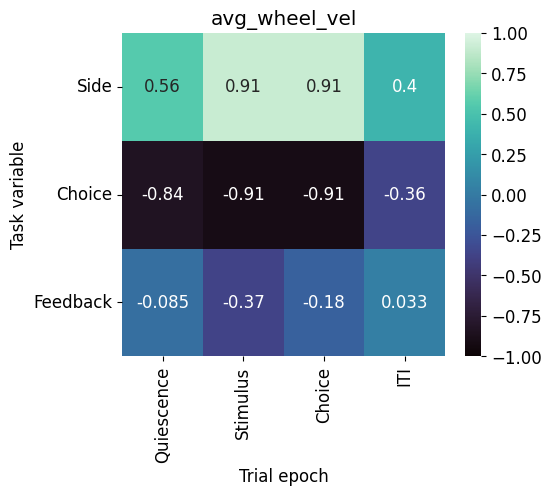

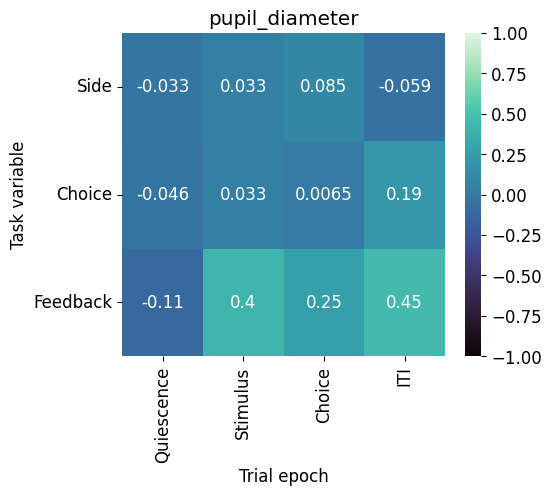

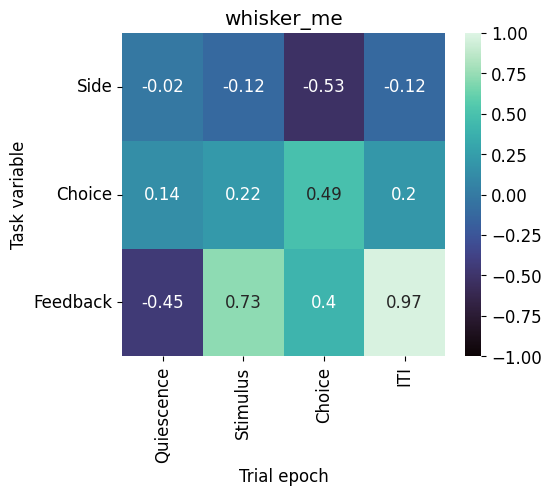

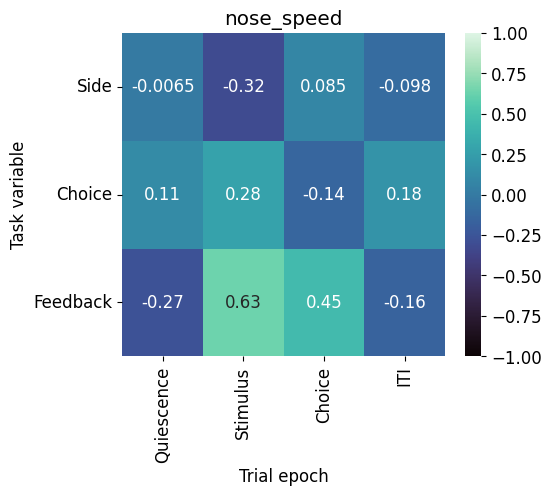

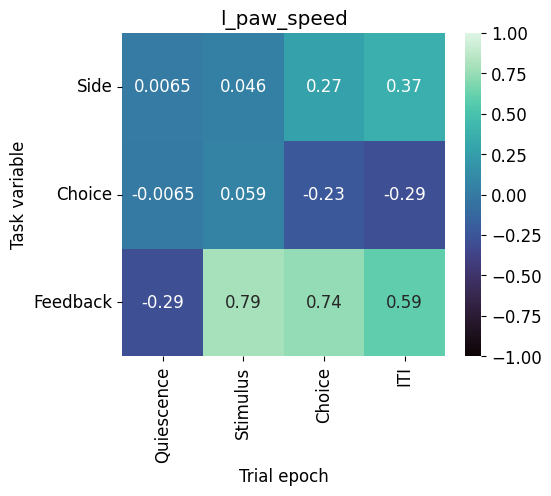

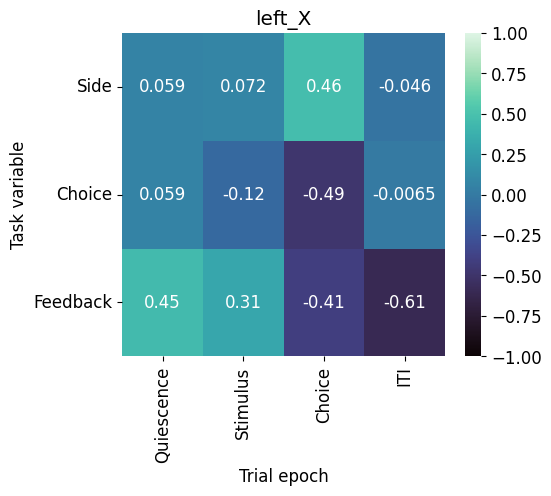

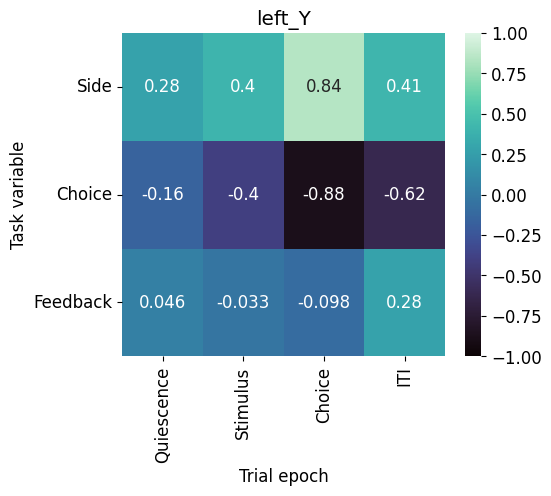

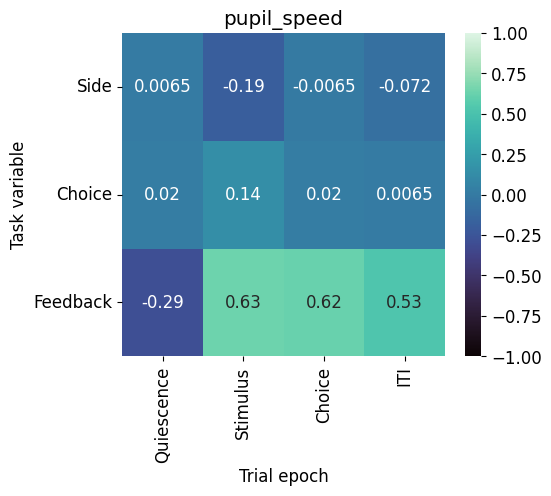

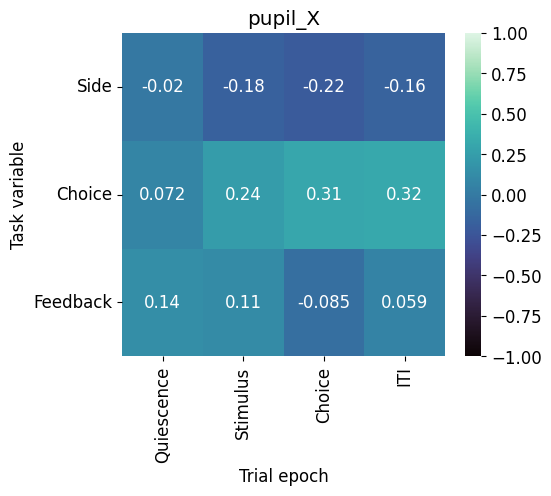

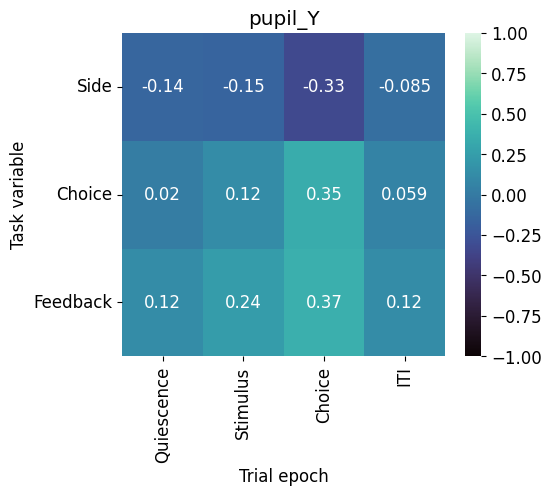

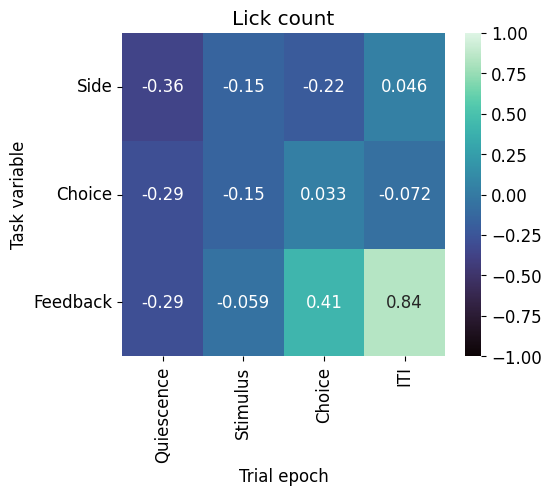

In [9]:
# Plot results
hue_vals = ['side', 'choice', 'feedback']
cross_stats['significance'] = cross_stats['p_value']
Bonferroni_corrected = 0.05 / (len(var_names) * len(hue_vals))
cross_stats.loc[cross_stats['p_value']>= Bonferroni_corrected, 'significance'] = 0
cross_stats.loc[cross_stats['p_value']< Bonferroni_corrected, 'significance'] = 1

cross_stats.loc[cross_stats['dom']=='-1', 'dom'] = -1
cross_stats.loc[cross_stats['dom']=='1', 'dom'] = 1

use_data = cross_stats.loc[cross_stats['significance']==1]
stats_summary =  cross_stats.groupby(['epoch', 'hue', 'var'])['dom'].mean()  
stats_summary = stats_summary.reset_index(level = [0, 1, 2]) 

mask =  cross_stats.groupby(['epoch', 'hue', 'var'])['significance'].mean()  
mask = mask.reset_index(level = [0, 1, 2]) 

# Define the desired sorting order
epoch_order = ['Quiescence', 'Stimulus', 'Choice', 'ITI']
hue_order = ['side', 'choice', 'feedback']
    
for v, var in enumerate(var_names):

    # Pivot
    use_data = stats_summary.loc[stats_summary['var']==var]
    df = use_data.pivot(index='hue', columns='epoch', values='dom')
    pivot_df = df[epoch_order].reset_index()
    sorted_df = pivot_df.sort_values(by='hue', key=lambda x: x.map({v: i for i, v in enumerate(hue_order)}))
    image_df = sorted_df[epoch_order]
    
    """
    PLOT RESULTS
    """

    # Results on original model
    plt.rc('font', size=12) 
    plt.figure(figsize=[5.2, 4.2])
    hmap = sns.color_palette("mako", as_cmap=True)
    data = image_df
    sns.heatmap(image_df, annot=True, 
        yticklabels=hue_order, xticklabels=epoch_order, 
        cmap= hmap, vmin=-1, vmax=1) 

    plt.xticks([.5, 1.5, 2.5, 3.5], epoch_order)
    plt.yticks([.5, 1.5, 2.5], ['Side', 'Choice', 'Feedback'], rotation=0)

    plt.xlabel('Trial epoch')
    plt.ylabel('Task variable')
    plt.title(var)
    plt.show()


## Plot significance across sessions

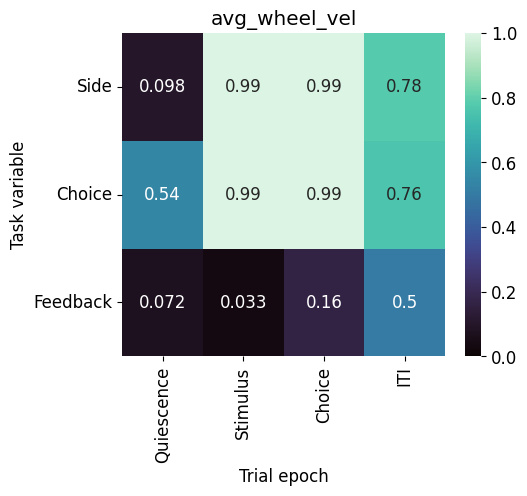

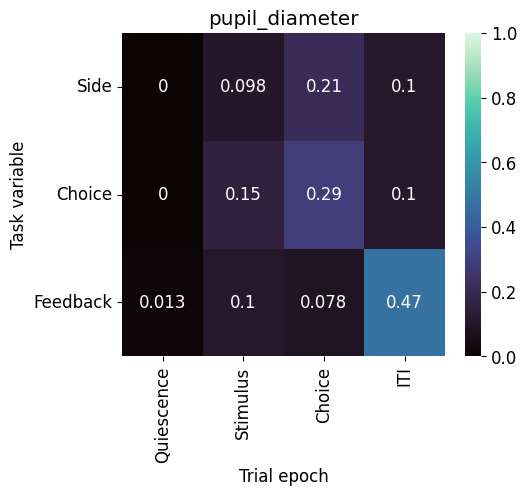

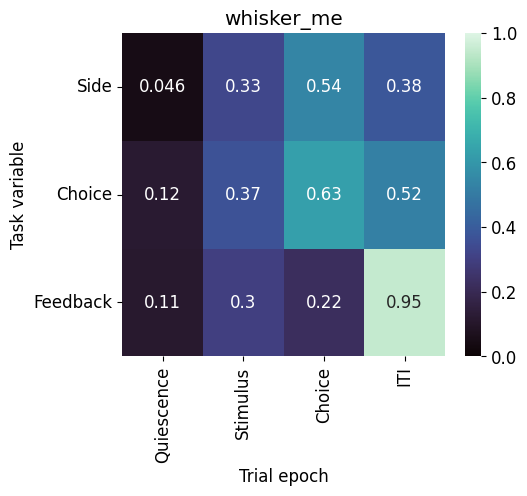

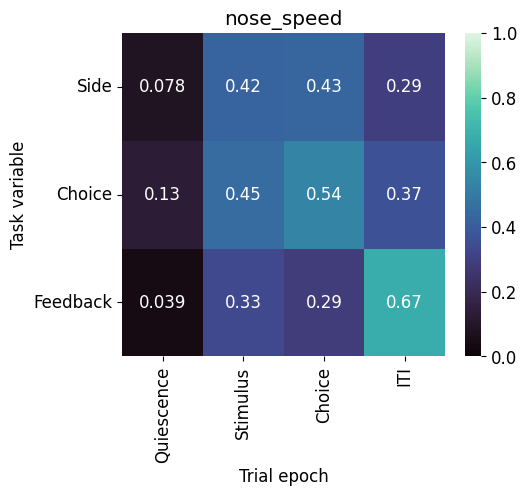

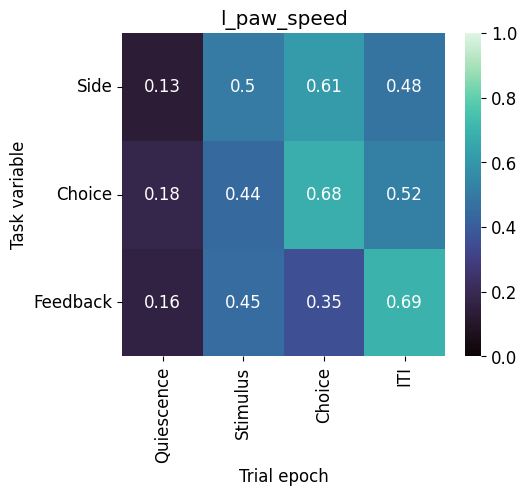

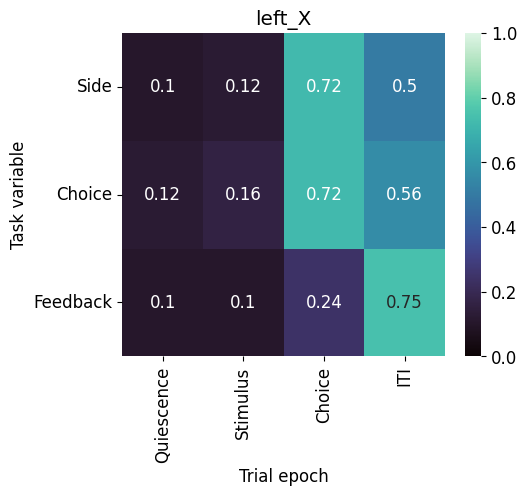

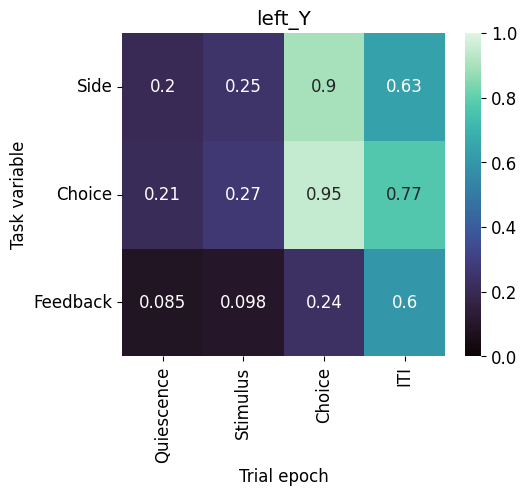

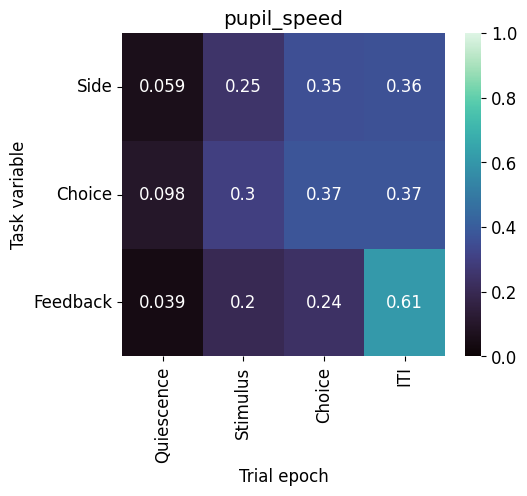

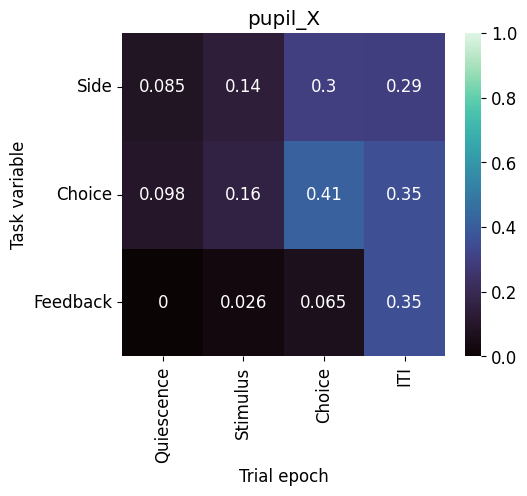

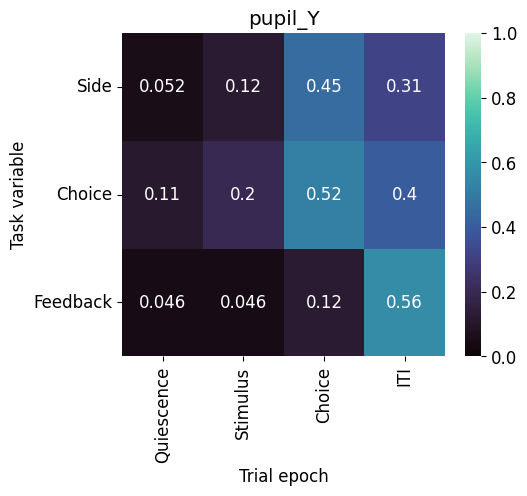

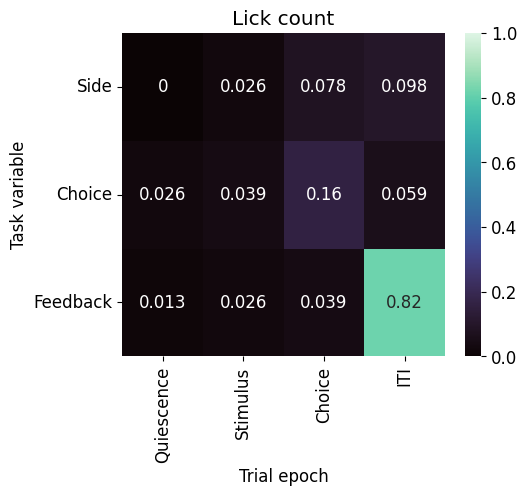

In [10]:
# Plot results
hue_vals = ['side', 'choice', 'feedback']
cross_stats['significance'] = cross_stats['p_value']
Bonferroni_corrected = 0.05 / (len(var_names) * len(hue_vals))
cross_stats.loc[cross_stats['p_value']>= Bonferroni_corrected, 'significance'] = 0
cross_stats.loc[cross_stats['p_value']< Bonferroni_corrected, 'significance'] = 1

stats_summary =  cross_stats.groupby(['epoch', 'hue', 'var'])['significance'].mean()  
stats_summary = stats_summary.reset_index(level = [0, 1, 2]) 

# Define the desired sorting order
epoch_order = ['Quiescence', 'Stimulus', 'Choice', 'ITI']
hue_order = ['side', 'choice', 'feedback']
    
for v, var in enumerate(var_names):

    # Pivot
    use_data = stats_summary.loc[stats_summary['var']==var]
    df = use_data.pivot(index='hue', columns='epoch', values='significance')
    pivot_df = df[epoch_order].reset_index()
    sorted_df = pivot_df.sort_values(by='hue', key=lambda x: x.map({v: i for i, v in enumerate(hue_order)}))
    image_df = sorted_df[epoch_order]
    
    """
    PLOT RESULTS
    """

    # Results on original model
    plt.rc('font', size=12) 
    plt.figure(figsize=[5.2, 4.2])
    hmap = sns.color_palette("mako", as_cmap=True)
    data = image_df
    sns.heatmap(image_df, annot=True, 
        yticklabels=hue_order, xticklabels=epoch_order, 
        cmap= hmap, vmin=0, vmax=1) 

    plt.xticks([.5, 1.5, 2.5, 3.5], epoch_order)
    plt.yticks([.5, 1.5, 2.5], ['Side', 'Choice', 'Feedback'], rotation=0)

    plt.xlabel('Trial epoch')
    plt.ylabel('Task variable')
    plt.title(var)
    plt.show()



## Correlate with performance

In [11]:
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))
            
perf_idx = pd.DataFrame(columns=['performance_easy', 'idx'])
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        
        perf_mouse = pd.DataFrame(columns=['performance_easy', 'idx'], index=range(1))
        
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        epoch_matrix = epoch_df[mouse_name][session]
        
        perf_mouse['idx'] = mat
        perf_mouse['performance_easy'] = np.nanmean(prepro(session_trials)['correct'])
        
        # Save overall results
        if m == 0:
            perf_idx = perf_mouse
        else:
            perf_idx = perf_idx.append(perf_mouse)


/tmp/ipykernel_13602/2591618750.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_idx = perf_idx.append(perf_mouse)
/tmp/ipykernel_13602/2591618750.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_idx = perf_idx.append(perf_mouse)
/tmp/ipykernel_13602/2591618750.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_idx = perf_idx.append(perf_mouse)
/tmp/ipykernel_13602/2591618750.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_idx = perf_idx.append(perf_mouse)
/tmp/ipykernel_13602/2591618750.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

Text(0.5, 0, 'Mean performance on easy trials')

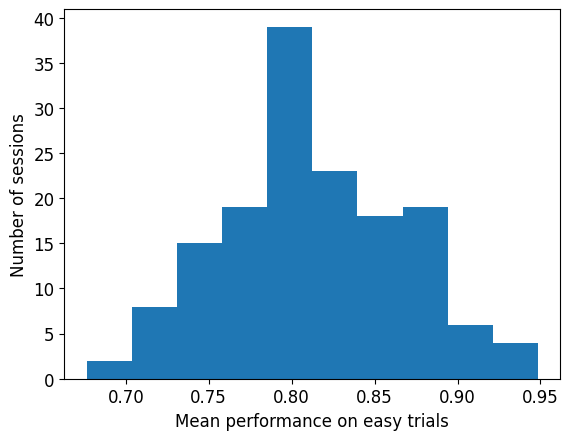

In [28]:
use_data = use_data.groupby(['idx']).mean(['performance_easy']).reset_index()
plt.hist(use_data.performance_easy)
plt.ylabel('Number of sessions')
plt.xlabel('Mean performance on easy trials')

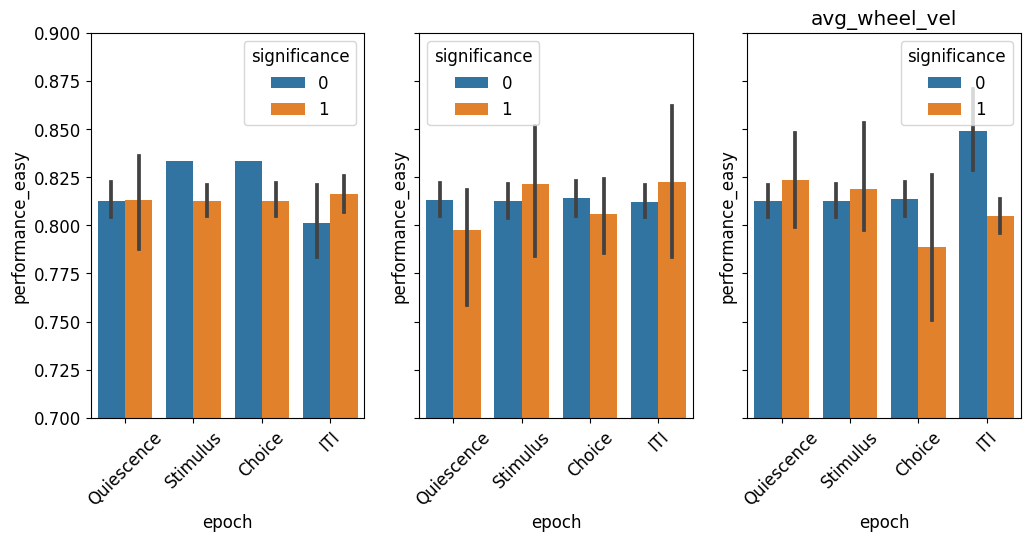

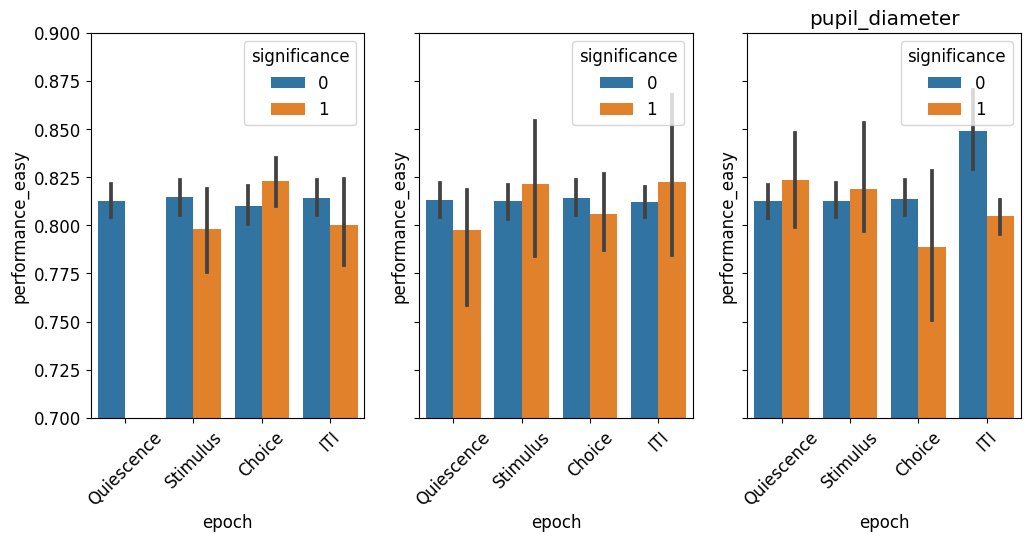

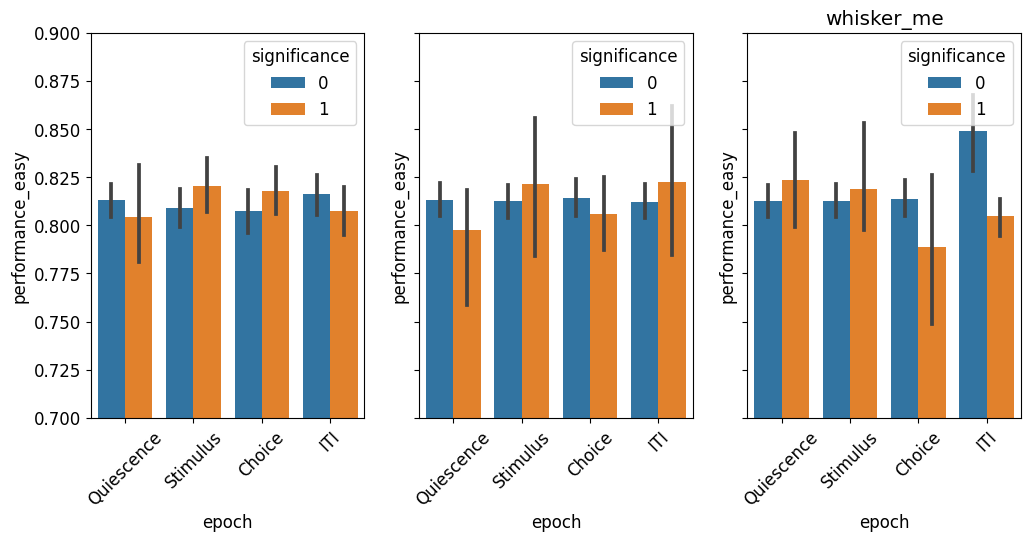

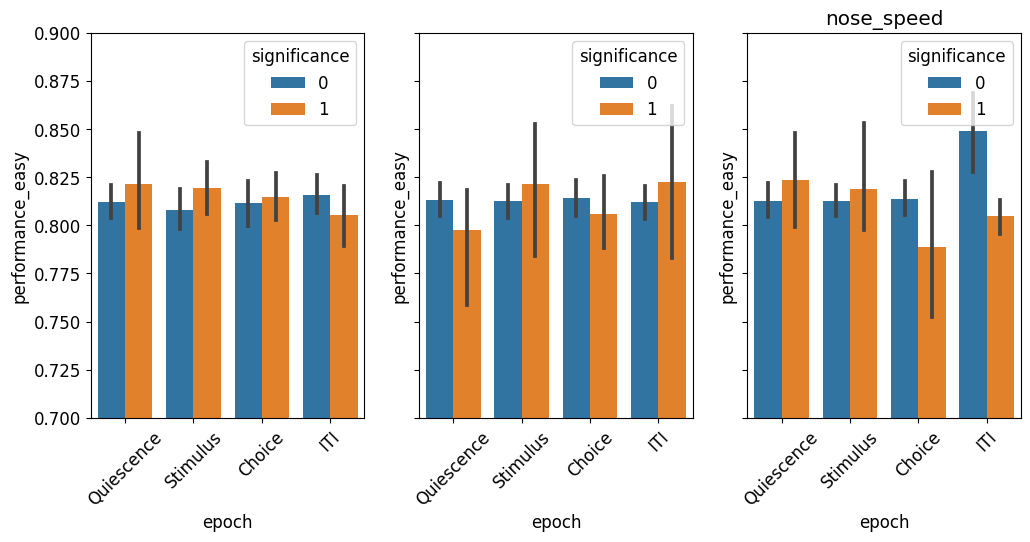

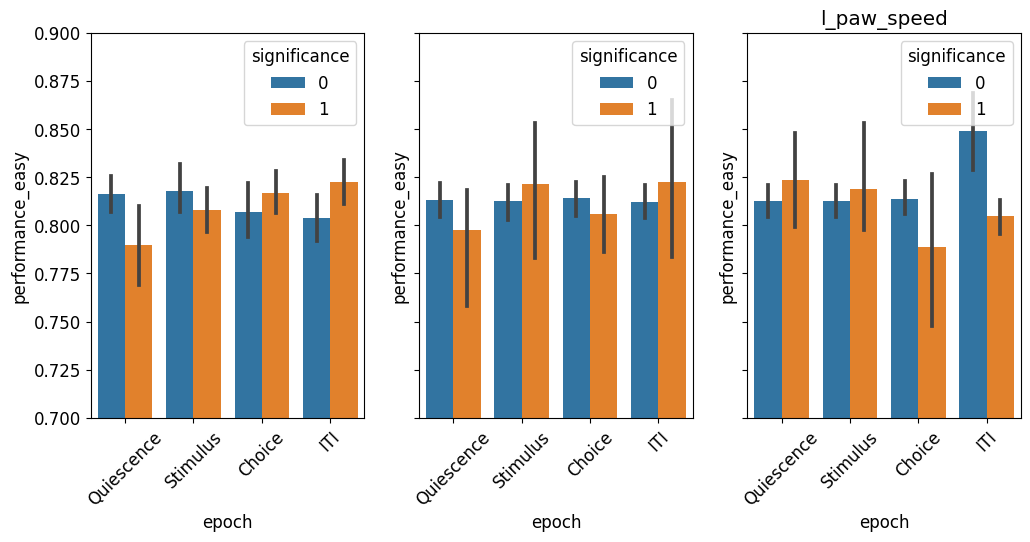

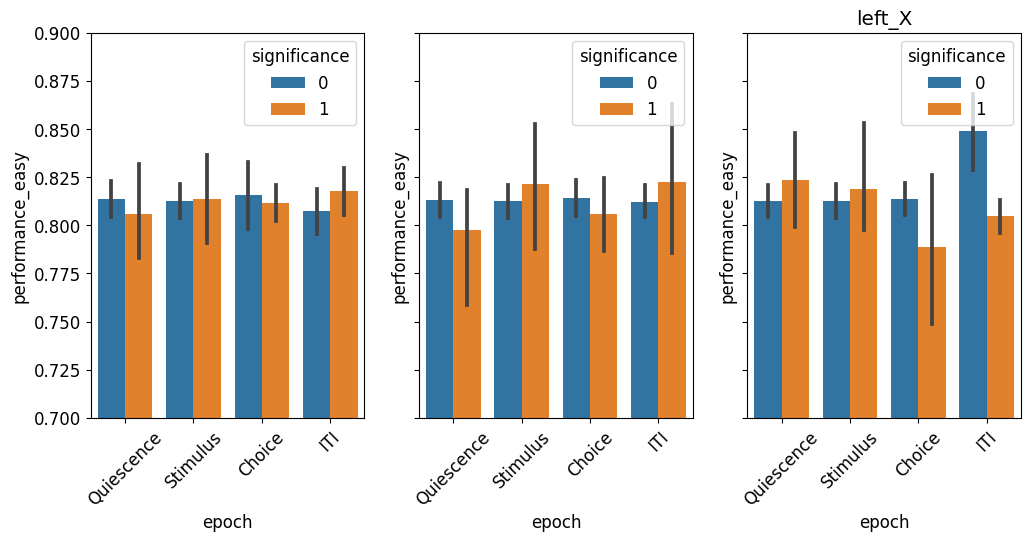

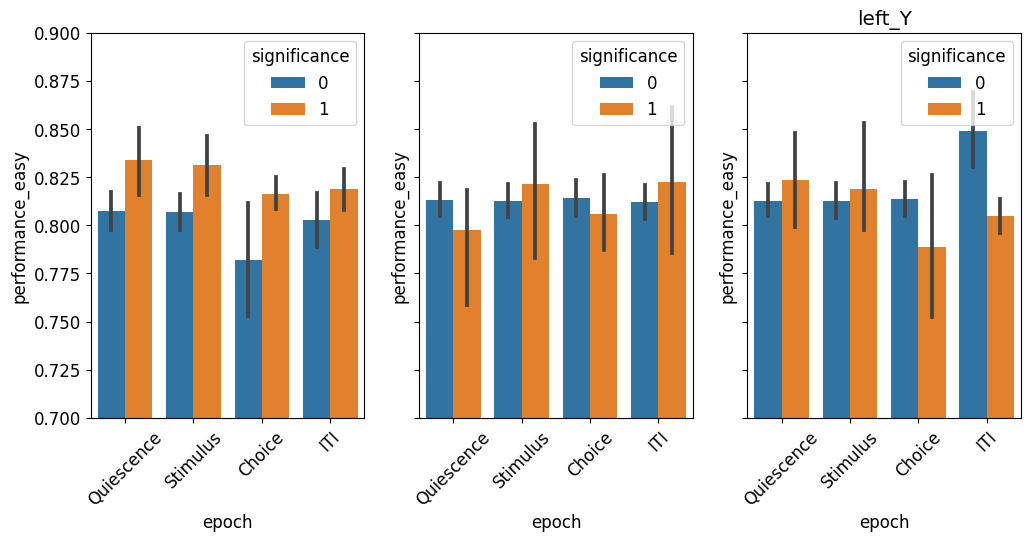

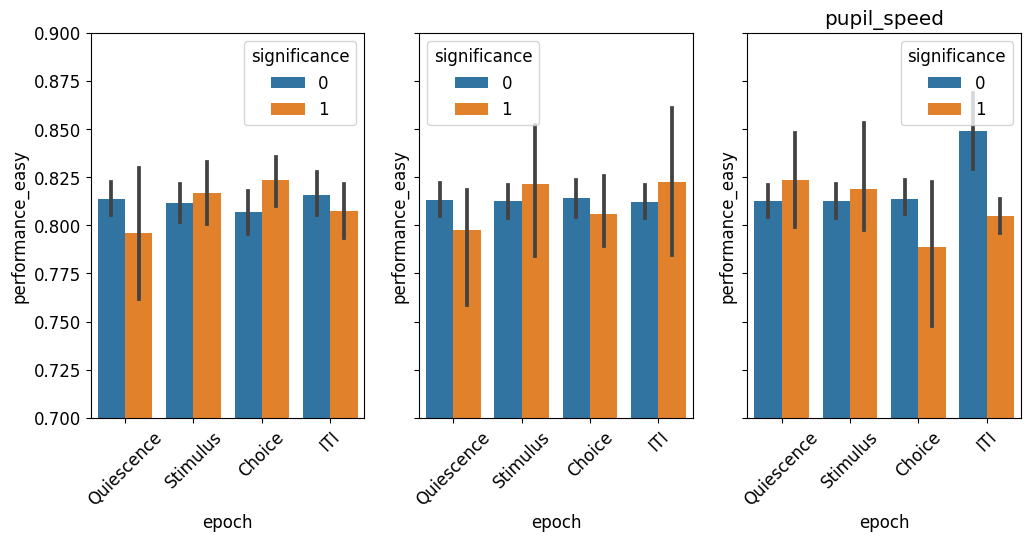

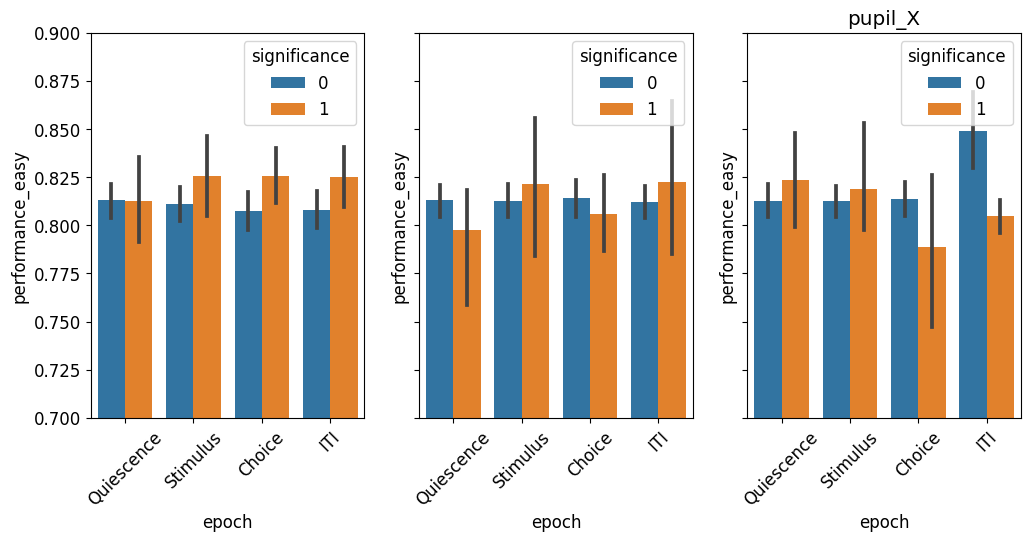

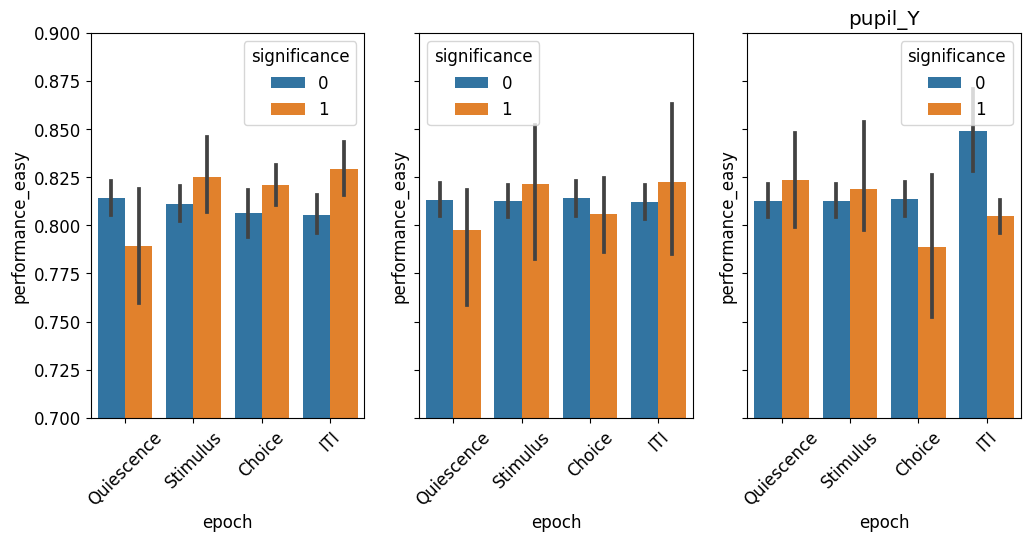

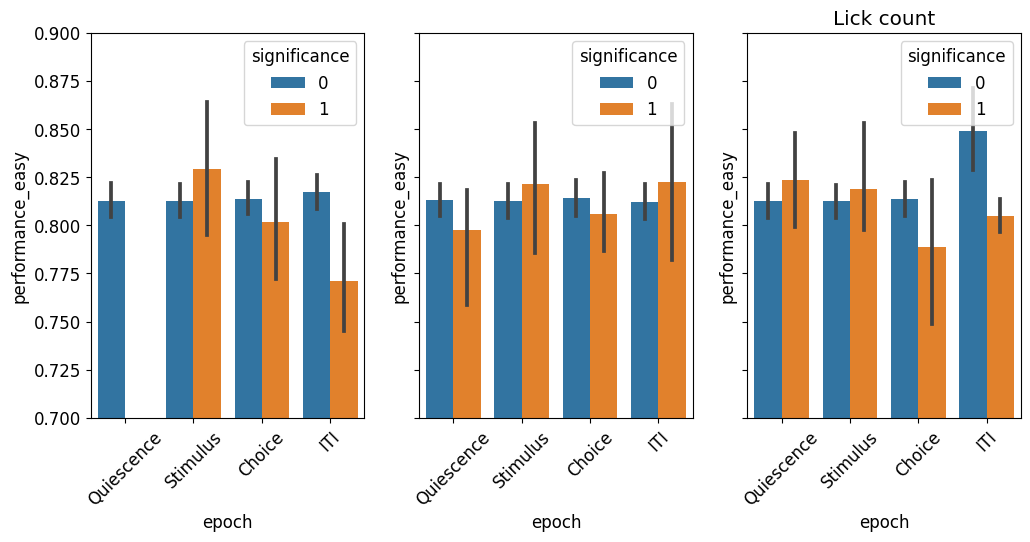

In [67]:
joint_df = cross_stats.merge(perf_idx, on=['idx'])

vars = joint_df['var'].unique()
for v, var in enumerate(vars):
    
    use_data = joint_df.loc[joint_df['var']==var]    
    use_data = use_data.groupby(['idx', 'epoch', 'significance', 'hue']).mean(['performance_easy']).reset_index()

    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=[12, 5])
    plt.ylim([0.7, 0.9])
    
    sns.barplot(x='epoch', y='performance_easy', hue='significance', data=use_data.loc[use_data['hue']=='side'], ax=axs[0], order=['Quiescence', 'Stimulus', 'Choice', 'ITI'])
    sns.barplot(x='epoch', y='performance_easy', hue='significance', data=sorted_df.loc[sorted_df['hue']=='choice'], ax=axs[1], order=['Quiescence', 'Stimulus', 'Choice', 'ITI'])
    sns.barplot(x='epoch', y='performance_easy', hue='significance', data=sorted_df.loc[sorted_df['hue']=='feedback'], ax=axs[2], order=['Quiescence', 'Stimulus', 'Choice', 'ITI'])
    
    axs[0].set_xticks([0, 1, 2, 3], ['Quiescence', 'Stimulus', 'Choice', 'ITI'], rotation=45)  # Orient x-axis ticks at 45 degrees
    axs[1].set_xticks([0, 1, 2, 3], ['Quiescence', 'Stimulus', 'Choice', 'ITI'], rotation=45)  # Orient x-axis ticks at 45 degrees
    axs[2].set_xticks([0, 1, 2, 3], ['Quiescence', 'Stimulus', 'Choice', 'ITI'], rotation=45)  # Orient x-axis ticks at 45 degrees
    plt.tight_layout
    plt.title(var)
    plt.show()
    